# Independent Groups Factorial ANOVA with Significant Interaction


In this notebook I will demonstrate how to run a two-way Factorial ANOVA, specifically a 2x3 ANOVA, where the data contains a significant interaction between the two independent variables (IVs).

The data is from a behavioural Game Theory study where participants played an economic game. Participants (N=48) played against one other participant and each player had to make a consumption decision in every round of the game about how much of a generalised resource they would like to consume. Participants accumulated points for their consumption decisions (number of units of the resource they chose to consume) but could overuse or destroy the resource base by making too large a consumption choice in any round. There was a stable optimum point for consumption decisions in any given round that gave a player their largest number of points whilst preserving the resource so a further round of the game could be played, where they could accumulate more points. Participants played the game in one of two anonymity conditions: (Seen/ Unseen), where they played the game face-to-face with their opponent or in separate rooms, so, they never met. A second variable was also included that manipulated the amount of information participants had available regarding the resource base (Known value: Participants knew how many units of the resource were available throughout the game; Low Uncertainty: Participants Did not know the starting value of the resource available but gained information as the game progressed; High Uncertainty: Participants never knew the value of the resource available, only whether it had decreased in value or refreshed to the starting value).

IV1: Anonymity (Two levels: Seen/ Unseen)

IV2: Information (Three levels: Known Value/ Low Uncertainty/ High Uncertainty).

DV: Mean Consumption Decision in the game.

In the below analysis, I demonstrate how to tidy the data so that the categories are correctly labelled; how to conduct a Levene's test to assess if homogeneity of variance can be assumed for the IVs; conduct a 2x3 IG ANOVA; and follow this up by conducting tests of simple effects to interpret a significant interaction between the IVs.

### Importing and tidying the data for analysis

In [1]:
# Importing key software libraries

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Importing dataset from csv file. 

consump_df = pd.read_csv('Consumption Example IG 2x3.csv')

consump_df.head()

,Anonymity,Information,Consumption
0,1,0,6
1,1,0,7
2,1,0,6
3,1,0,7
4,1,0,6


In [3]:
consump_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Anonymity    48 non-null     int64
 1   Information  48 non-null     int64
 2   Consumption  48 non-null     int64
dtypes: int64(3)
memory usage: 1.2 KB


We can see that the two categorical variables (Anonymity and Information) have been numerically coded so that the different categories are represented by numbers (0 and 1 for Anonymity; 0, 1 and 2 for Information). This has resulted in pandas intepreting them as integers rather than categorical objects. The first thing I need to do with this dataset is turn these two variables in objects that have meaningful labels for each category. This will help with understanding and intepreting output later on in the analysis.

In [4]:
# Creating two new variables that represent the category labels for Anonymity and Information
# and appending them to the dataframe. 

# Using the series.map function to add labels to the Anonymity categorical variable.

a = [0, 1]
b = ["seen", "unseen"]

consump_df['anon_cat'] = consump_df['Anonymity'].map(dict(zip(a, b)))

In [5]:
# Using the series.map function to add labels to the Information categorical variable.

a = [0, 1, 2]
b = ["known", "low_unc", "high_unc"]

consump_df['info_cat'] = consump_df['Information'].map(dict(zip(a, b)))

In [6]:
consump_df.head()

,Anonymity,Information,Consumption,anon_cat,info_cat
0,1,0,6,unseen,known
1,1,0,7,unseen,known
2,1,0,6,unseen,known
3,1,0,7,unseen,known
4,1,0,6,unseen,known


In [7]:
# Checking the data type for these new variables.
# Both the new variables are shown as objects. They should be in the appropriate format for analysis. 
consump_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Anonymity    48 non-null     int64 
 1   Information  48 non-null     int64 
 2   Consumption  48 non-null     int64 
 3   anon_cat     48 non-null     object
 4   info_cat     48 non-null     object
dtypes: int64(3), object(2)
memory usage: 2.0+ KB


### Levene's test for Homogeneity of Variance

Levene's test is used to assess if the different groups in a categorical IV have equal variances. It is a common test of assumption for parameteric ANOVA tests. Here I will use the levene method from the pingouin software library. 

In [8]:
import pingouin as pg

In [9]:
pg.homoscedasticity(consump_df, dv = 'Consumption', group = 'anon_cat', center = 'mean')

,W,pval,equal_var
levene,6.136714,0.016976,False


In [11]:
pg.homoscedasticity(consump_df, dv = 'Consumption', group = 'info_cat', center = 'mean')

,W,pval,equal_var
levene,2.829613,0.069577,True


Here we have one significant Levene's test for the anonymity variable (F(1, 46) = 6.14, p = 0.02) and a non-significant Levene's test for the information variable (F(2, 45) = 2.83, p = 0.07). This suggests we are safe to assume equal variances on only one of the IVs. This is problematic but our best approach with factorial ANOVA is to run the ANOVA model and then if there is a significant main effect for the IV for which it is not safe to assume equal variances, we could run a robust one-way ANOVA (e.g. Welch's ANOVA) on that variable in isolation to assess if the main effect is still significant when using a stricter test.

### 2x3 Factorial ANOVA

Below is am going to run the 2x3 ANOVA. There are a number of optoins for conducting this analysis in python. On this occasion I will use the anova_lm method from the statsmodels software library. This method for fitting ANOVA models uses the same style of formula as used in the R programming language. 

In [12]:
# Importing statsmodels and the ols method. 

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [13]:
# Fitting a linear model containing only categorical IVs and the interaction between those IVs (c(anon_cat):c(info_cat))
consump_lm = ols('Consumption ~ C(anon_cat) + C(info_cat) + C(anon_cat):C(info_cat)', data = consump_df).fit()

# Using the anova_lm method and passing the linear model in as an argument for the method. 
aov_consump = sm.stats.anova_lm(consump_lm)

aov_consump

,df,sum_sq,mean_sq,F,PR(>F)
C(anon_cat),1.0,21.333333,21.333333,15.582609,0.000295
C(info_cat),2.0,16.541667,8.270833,6.041304,0.004943
C(anon_cat):C(info_cat),2.0,23.291667,11.645833,8.506522,0.000791
Residual,42.0,57.500000,1.369048,NaN,NaN


The ANOVA output table indicates that there is a significant main effect of anonymity (anon_cat: F(1, 42) = 15.58, p < 0.001), a significant main effect of information (info_cat: F(2, 42) = 6.04, p = 0.004), and a significant interaction between anonymity and information (anon_cat * info_cat: F(2, 42) = 8.51, p < 0.001). 

These results suggest that there is a significant difference between the anonymity groups in terms of their mean consumption (anonymity main effect), a significant difference between the information groups in terms of their mean consumption (information main effect) when the effect of these IVs on the DV is considered in isolation. However, we also have a significant interaction between these variables and the DV. This means that the pattern of differences on the DV for one IV is not the same when considered across all levels of the other IV. This tells is that the main effects are not consistent and in order to understand what is going on we need to interpret the interaction effect by holding each level of one IV constant and comparing differences between groups on the other IV. This means breaking the two IVs down into more granular groups and conducting a series of follow-up analyses. These tests are referred to as tests of simple effects. 

The following five tests of simple effects are required to understand the significant interaction:

- A one-way ANOVA comparing all 3 levels of information in the Unseen (Anonymity) condition. 
- A one-way ANOVA comparing all 3 levels of information in the Seen (Anonymity) condition. 
- A one-way ANOVA (or Bonferroni corrected t-test) comparing both levels of Anonymity in the Known Value (Information) condition. 
- A one-way ANOVA (or Bonferroni corrected t-test comparing both levels of Anonymity in the Low Uncertainty (Information) condition. 
- A one-way ANOVA (or Bonferroni corrected t-test comparing both levels of Anonymity in the High Uncertainty (Information) condition. 


### Tests of simple effects on the significant interaction

To conduct tests of simple effects on the significant interaction I am going to proceed by creating a column in the dataframe that contains all possible group combinations of the IVs in the interaction term. I will then use the MultiComparison method and tukeyhsd from statsmodels. 

In [14]:
# Importing multicomp from statsmodels, creating the interaction groups, and running tukeyhsd for all adjusted
# pairwise comparisons. 

import statsmodels.stats.multicomp as mc

interaction_groups = "anon_" + consump_df.anon_cat.astype(str) + "&" + "info_" + consump_df.info_cat.astype(str)

comp = mc.MultiComparison(consump_df["Consumption"], interaction_groups)
simp_eff_res = comp.tukeyhsd()
simp_eff_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
anon_seen&info_high_unc,anon_seen&info_known,-3.125,0.0,-4.8715,-1.3785,True
anon_seen&info_high_unc,anon_seen&info_low_unc,-1.75,0.0493,-3.4965,-0.0035,True
anon_seen&info_high_unc,anon_unseen&info_high_unc,-0.5,0.955,-2.2465,1.2465,False
anon_seen&info_high_unc,anon_unseen&info_known,-0.25,0.9981,-1.9965,1.4965,False
anon_seen&info_high_unc,anon_unseen&info_low_unc,-0.125,0.9999,-1.8715,1.6215,False
anon_seen&info_known,anon_seen&info_low_unc,1.375,0.1975,-0.3715,3.1215,False
anon_seen&info_known,anon_unseen&info_high_unc,2.625,0.0007,0.8785,4.3715,True
anon_seen&info_known,anon_unseen&info_known,2.875,0.0002,1.1285,4.6215,True
anon_seen&info_known,anon_unseen&info_low_unc,3.0,0.0001,1.2535,4.7465,True
anon_seen&info_low_unc,anon_unseen&info_high_unc,1.25,0.289,-0.4965,2.9965,False


The above results indicate that we have significant differences between mean consumption between a number of groups:

- Participants in the seen & high uncertainty group had significantly higher consumption than participants in the seen & known info group (p < 0.001. 
- Participants in the seen & high uncertain group had significantly higher consumption than participants in the seen & low uncertainty group (p = 0.05).
- Participants in the seen & known info group had significantly lower mean consumption than participants in the unseen & high uncertainty group (p = 0.0007). 
- Participants in the seen & known info group had significantly lower mean consumption than participants in the unseen & known info group (p = 0.0002).
- Participants in the seen & known info group had significantly lower mean consumption than participants in the unseen & low uncertainty info group (p = 0.0001). 


An interaction plot and descriptive statistics can be helpful ways to visualise and interpret the effect the interaction is having. We can see in the below plot the signficant difference between seen and unseen in the known category, between seen and unseen in the low uncertainty category, but no difference between seen and unseen in the high uncertainty category. 
Further, when just considering the information groups in the unseen category (the blue line) there are no significant differences between the groups in terms of consumption and the line is almost completely flat. In contrast, when just looking at the seen condition (the orange line) we can see that there are significant differences in consumption between the known and high uncertainty group, and between the low uncertainty and high uncertainty group. There was no significant difference between the known and low uncertinty group however, and this can be seen by the overlap in confidence intervals between those two groups on the orange line. 

<AxesSubplot:xlabel='info_cat', ylabel='Consumption'>

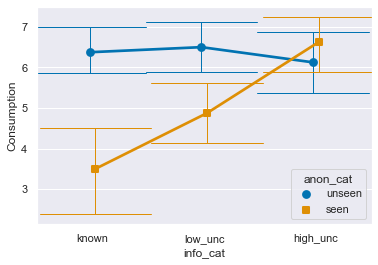

In [15]:
# Creating an interaction plot to visualise the differences between the group means using seaborn pointplot.

sns.set()
sns.pointplot(data = consump_df, x = 'info_cat', y = 'Consumption', hue = 'anon_cat', dodge = True, 
              markers = ['o', 's'], capsize = 1, errwidth = 1, palette = 'colorblind')

A table of descriptive statistics, particularly means for each interaction group would also be useful. 

In [16]:
# First appending the interaction_groups column to the consumption data frame. 

consump_df["inter_grp"] = interaction_groups

consump_df.head()

,Anonymity,Information,Consumption,anon_cat,info_cat,inter_grp
0,1,0,6,unseen,known,anon_unseen&info_known
1,1,0,7,unseen,known,anon_unseen&info_known
2,1,0,6,unseen,known,anon_unseen&info_known
3,1,0,7,unseen,known,anon_unseen&info_known
4,1,0,6,unseen,known,anon_unseen&info_known


In [17]:
# Next obtaining descriptive statistics by interaction group for comparison. 

# Creating a new object for each of the interaction groups:

unseen_known = consump_df.loc[consump_df.inter_grp == 'anon_unseen&info_known']['Consumption']
unseen_low = consump_df.loc[consump_df.inter_grp == 'anon_unseen&info_low_unc']['Consumption']
unseen_high = consump_df.loc[consump_df.inter_grp == 'anon_unseen&info_high_unc']['Consumption']
seen_known = consump_df.loc[consump_df.inter_grp == 'anon_seen&info_known']['Consumption']
seen_low = consump_df.loc[consump_df.inter_grp == 'anon_seen&info_low_unc']['Consumption']
seen_high = consump_df.loc[consump_df.inter_grp == 'anon_seen&info_high_unc']['Consumption']

In [18]:
# Printing the mean for each of the above interaction group objects. 

print(f"Unseen & Known mean: {unseen_known.mean():.2f}")
print(f"Unseen & Low mean: {unseen_low.mean():.2f}")
print(f"Unseen & High mean: {unseen_high.mean():.2f}")
print(f"Seen & Known mean: {seen_known.mean():.2f}")
print(f"Seen & Low mean: {seen_low.mean():.2f}")
print(f"Seen & High mean: {seen_high.mean():.2f}")

Unseen & Known mean: 6.38
Unseen & Low mean: 6.50
Unseen & High mean: 6.12
Seen & Known mean: 3.50
Seen & Low mean: 4.88
Seen & High mean: 6.62


The Tukey HSD pairwise comparisons, the interaction plot and the mean scores broken down by interaction group help us to make sense of and understand the interaction. The general story that this dataset tell us is that when participants could not see the other player against whom they were playing (unseen condition) they made significantly higher consumption decisions than players who were face-to-face with the other player (seen condition). However, this was not consistent and when there was high uncertainty in games about how much of the resource existed, players in both the seen and unseen conditions made similarly high consumption decisions. 